##### Imports

In [2]:
import asvFormula.bayesianNetworks.bayesianNetwork as bn
import asvFormula.experiments as exp
from asvFormula import asvRunResultsPath
from asvFormula.datasetManipulation import *
import asvFormula.exactASV as exact
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

cancerExactASVFile = asvRunResultsPath + "/cancerASVAndShapleyExact.csv"
childExactASVFile = asvRunResultsPath + "/childASVAndShapleyExact.csv"

seeds = [12,32,53,420,5]

In [2]:
from importlib import reload 
import asvFormula
import asvFormula.bayesianNetworks.bayesianNetwork as bn
import asvFormula.exactASV as exact

bn = reload(asvFormula.bayesianNetworks.bayesianNetwork)
exact = reload(asvFormula.exactASV)


## Generating the results 

### Running ASV for Cancer bayesian network

#### Train the decision tree model

In [ ]:
for seed in seeds:
    cancerBNmodel, variableToPredict, numberOfSamples, treeMaxDepth = exp.cancerNetworkConfig()

    BNInference, valuesPerFeature, encodedDataset, dtTreeClassifier, dtAsNetwork = initializeDataAndRemoveVariable(cancerBNmodel, variableToPredict, numberOfSamples, treeMaxDepth, seed)

    dataNoPrediction = encodedDataset.drop(variableToPredict, axis=1)
    first_instance = dataNoPrediction.iloc[0]

    asvCalc = exact.ASV(cancerBNmodel, dtTreeClassifier, BNInference, valuesPerFeature, variableToPredict, predictionFunction='Exact')

    if os.path.exists(cancerExactASVFile):
        os.remove(cancerExactASVFile) #Remove the file to reset results
    exp.writeASVAndShapleyIntoFile(first_instance, dataNoPrediction, dtTreeClassifier, asvCalc, cancerExactASVFile , valuesPerFeature, variableToPredict, seed)

  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.8083333333333333


  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.7416666666666667


  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.7583333333333333


  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.725


  0%|          | 0/5 [00:00<?, ?it/s]

The model accuracy is : 0.7583333333333333


"\nasvCalc = exact.ASV(cancerBNmodel, dtTreeClassifier, BNInference, valuesPerFeature, variableToPredict, predictionFunction = 'Mean')\n\nexp.writeASVAndShapleyIntoFile(first_instance, dataNoPrediction, dtTreeClassifier, asvCalc, cancerExactASVFile, valuesPerFeature, variableToPredict)\n"

### Running ASV for Child bayesian network

#### Train the decision tree model

In [16]:
for seed in seeds:
    treeBNChild, variableToPredict, numberOfSamples, treeMaxDepth = exp.childNetworkConfig()

    BNInference, valuesPerFeature, encodedDataset, dtTreeClassifier, dtAsNetwork = initializeDataAndRemoveVariable(treeBNChild, variableToPredict, numberOfSamples, treeMaxDepth, seed)

    dataNoPrediction = encodedDataset.drop(variableToPredict, axis=1)
    first_instance = dataNoPrediction.iloc[0]

    asvCalc = exact.ASV(treeBNChild, dtTreeClassifier, BNInference, valuesPerFeature, variableToPredict, predictionFunction='Exact')

    if os.path.exists(cancerExactASVFile):
        os.remove(cancerExactASVFile) #Remove the file to reset results
    exp.writeASVAndShapleyIntoFile(first_instance, dataNoPrediction, dtTreeClassifier, asvCalc, childExactASVFile , valuesPerFeature, variableToPredict, seed)
    #This takes 20 minutes to run

  0%|          | 0/20 [00:00<?, ?it/s]

The model accuracy is : 0.674


  0%|          | 0/20 [00:00<?, ?it/s]

The model accuracy is : 0.6695


  0%|          | 0/20 [00:00<?, ?it/s]

The model accuracy is : 0.65


  0%|          | 0/20 [00:00<?, ?it/s]

The model accuracy is : 0.677


  0%|          | 0/20 [00:00<?, ?it/s]

The model accuracy is : 0.675


## Plotting the results 

### Converting to numerical data

In [23]:
plotsResultsFolder = 'results/plots/'

def dataframeFromCsv(path, seed=None):
    df = pd.read_csv(path)
    for column in ['ASV', 'Shapley']:
        df[column] = pd.to_numeric(df[column], errors='coerce')
    
    df = df[df['Seed'] == seed]
    df.name = path.split('/')[-1][:-4]
    return df

dfCancerExactDict = {}
for seed in seeds:
    dfCancerExactDict[seed] = dataframeFromCsv(cancerExactASVFile, seed=seed)


dfChildExactDict = {}
for seed in seeds:
    dfChildExactDict[seed] = dataframeFromCsv(childExactASVFile, seed=seed)

### Plotting ASV values for each feature

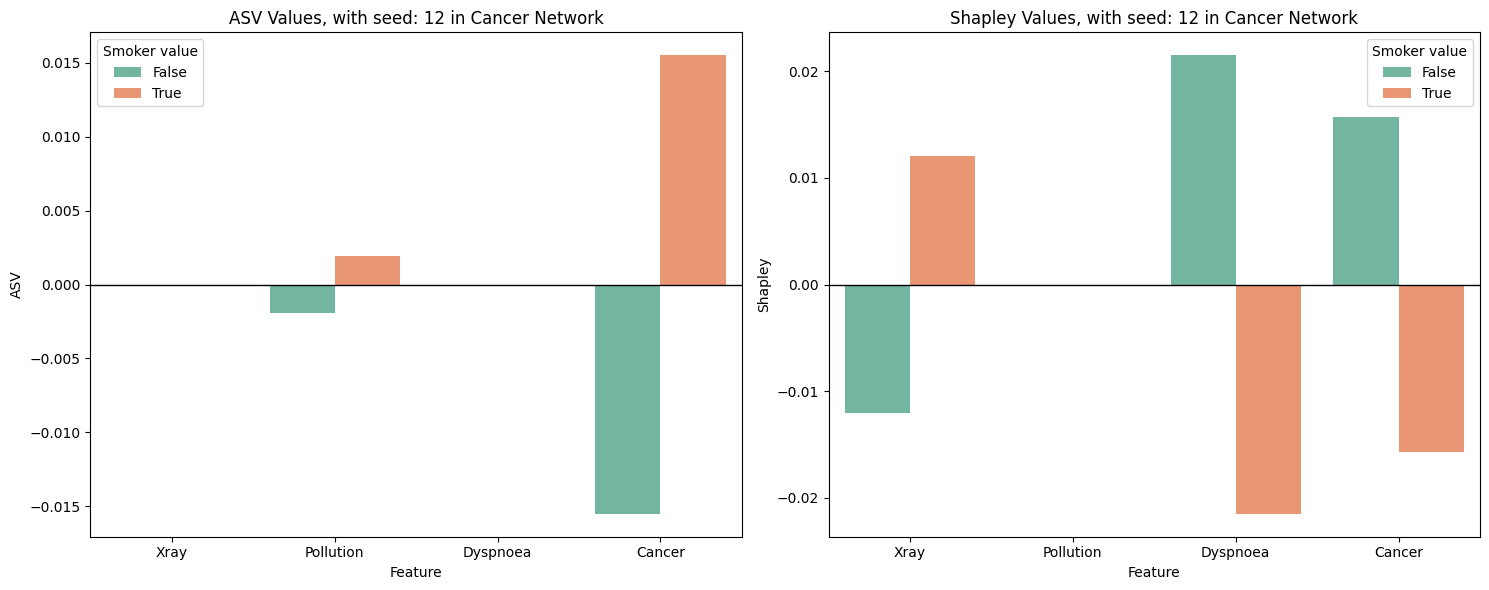

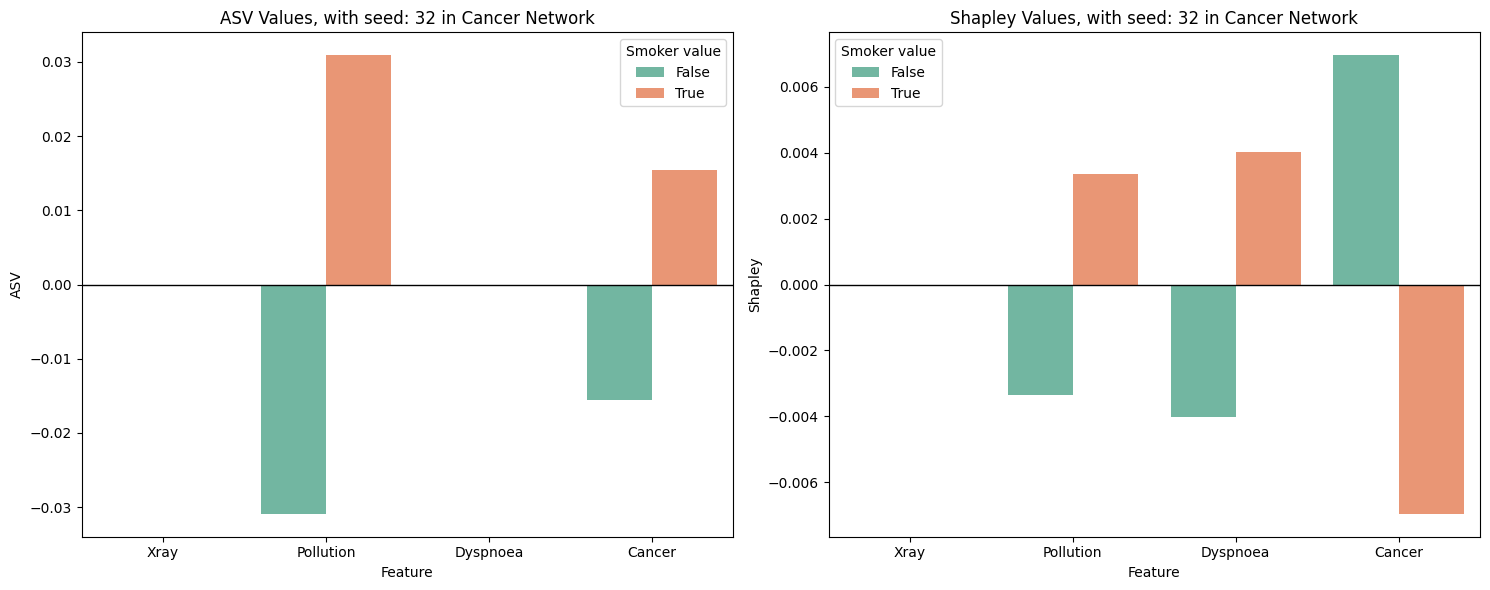

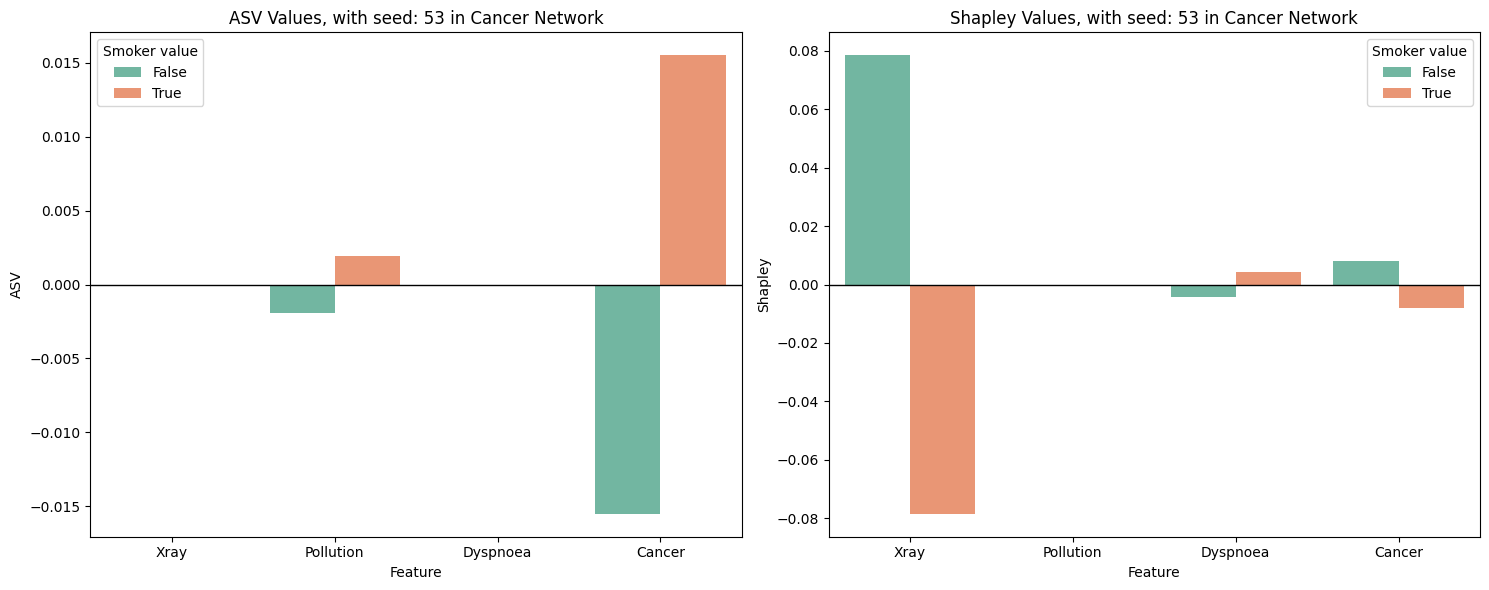

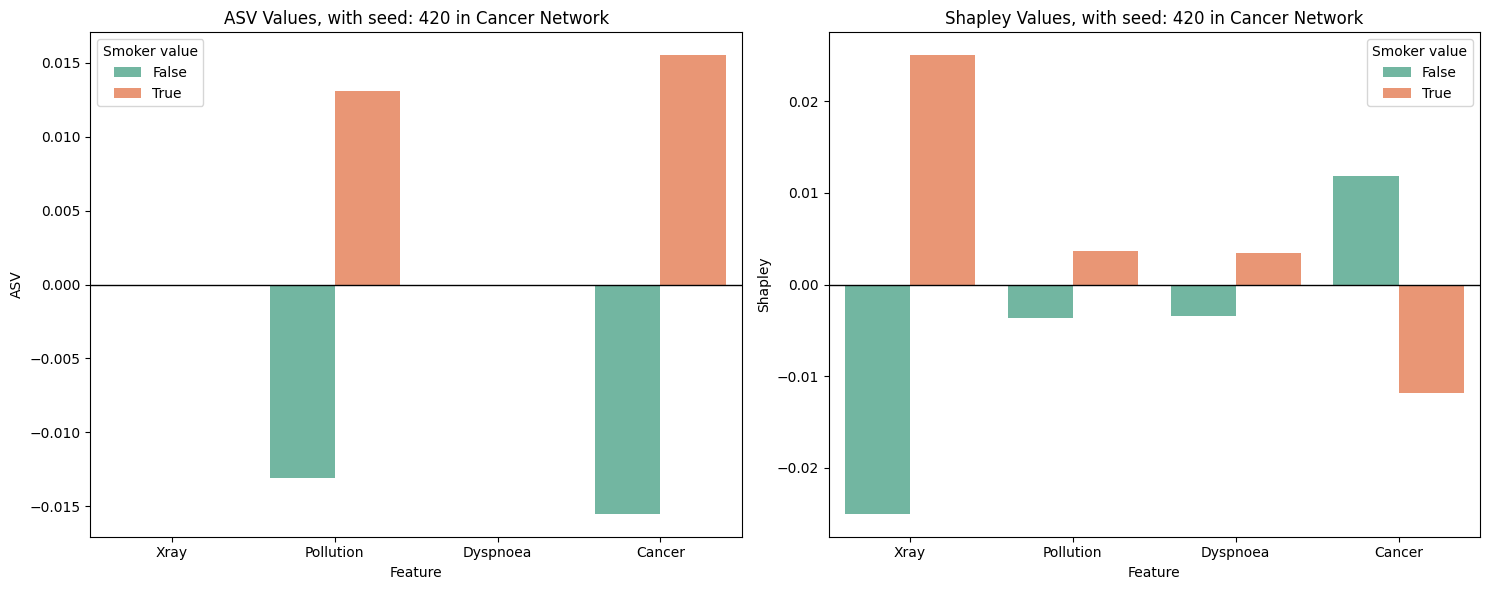

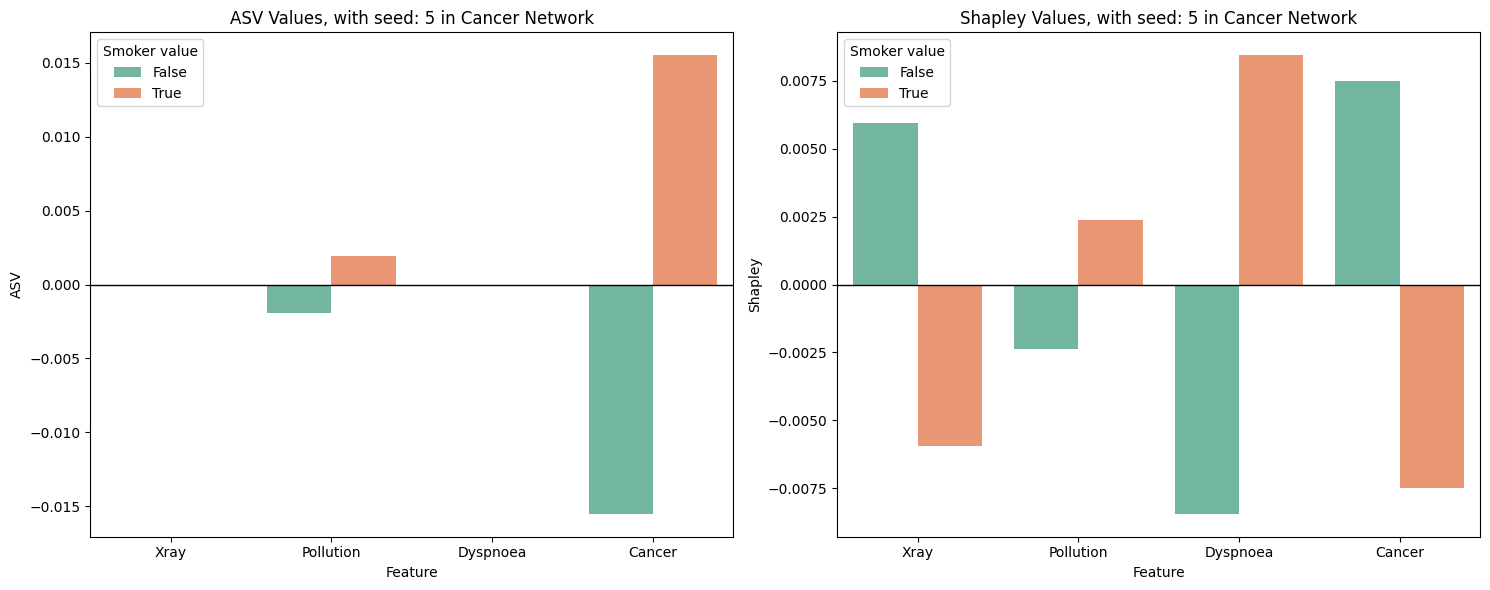

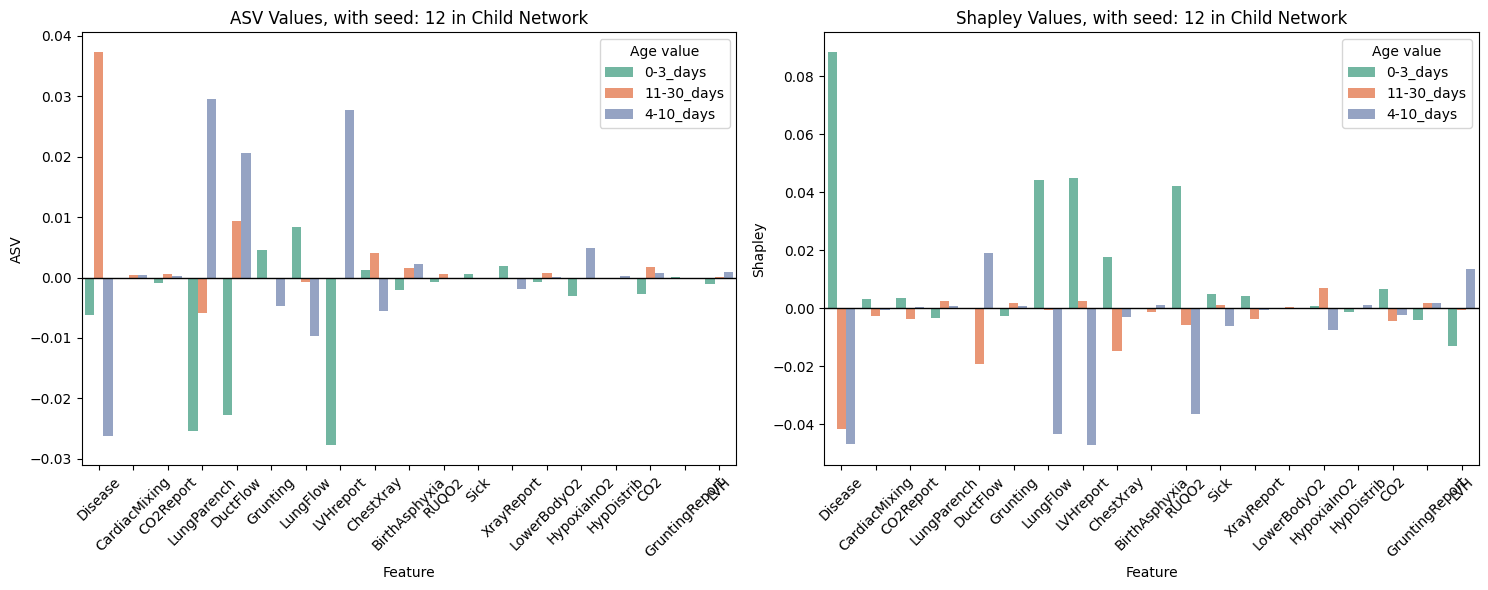

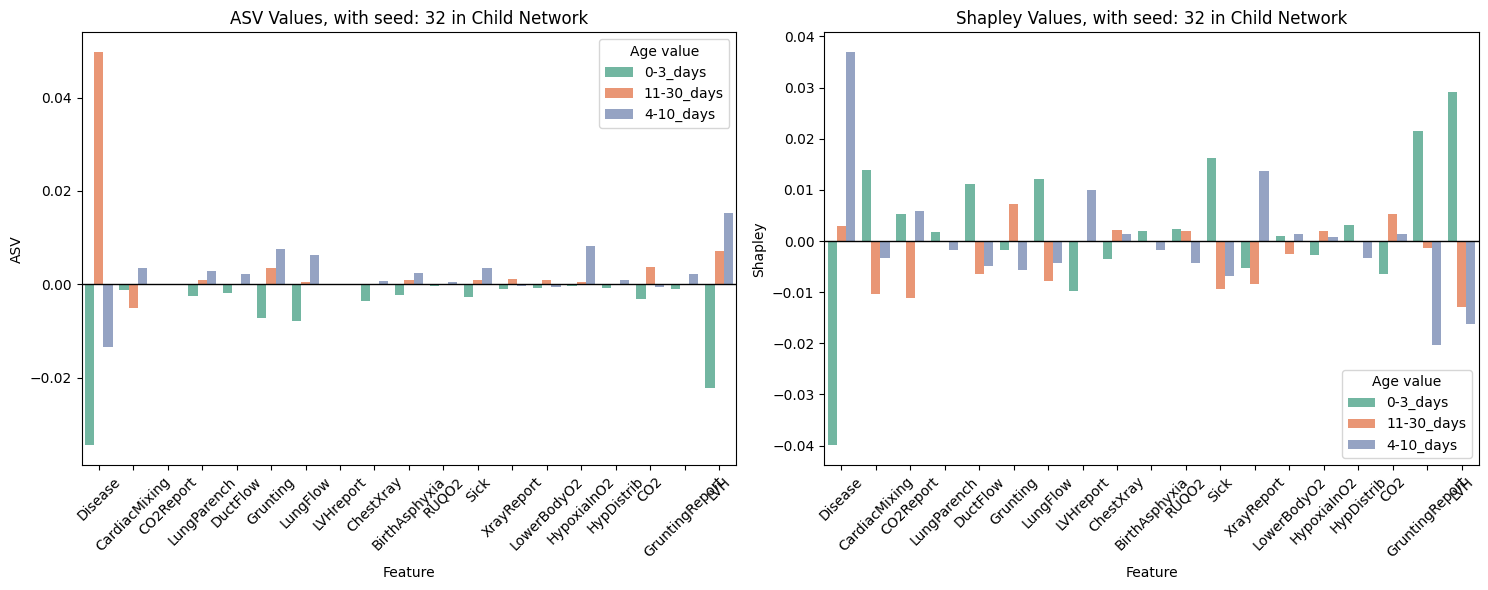

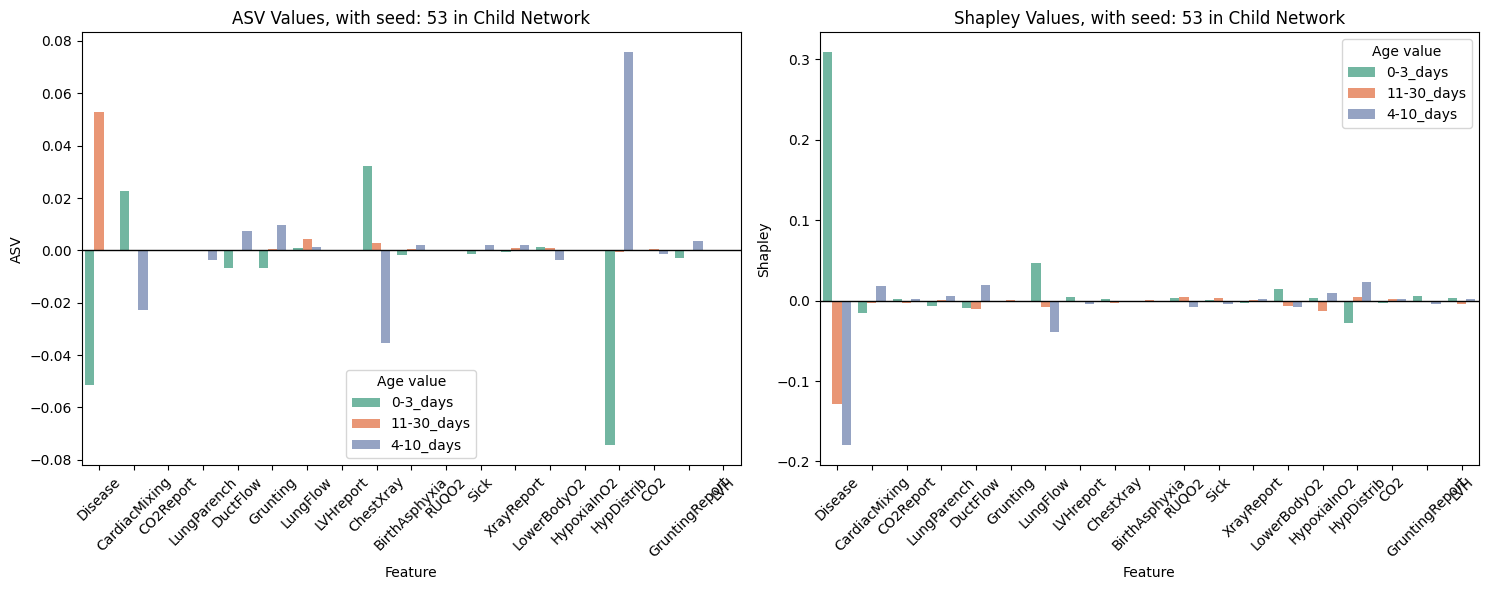

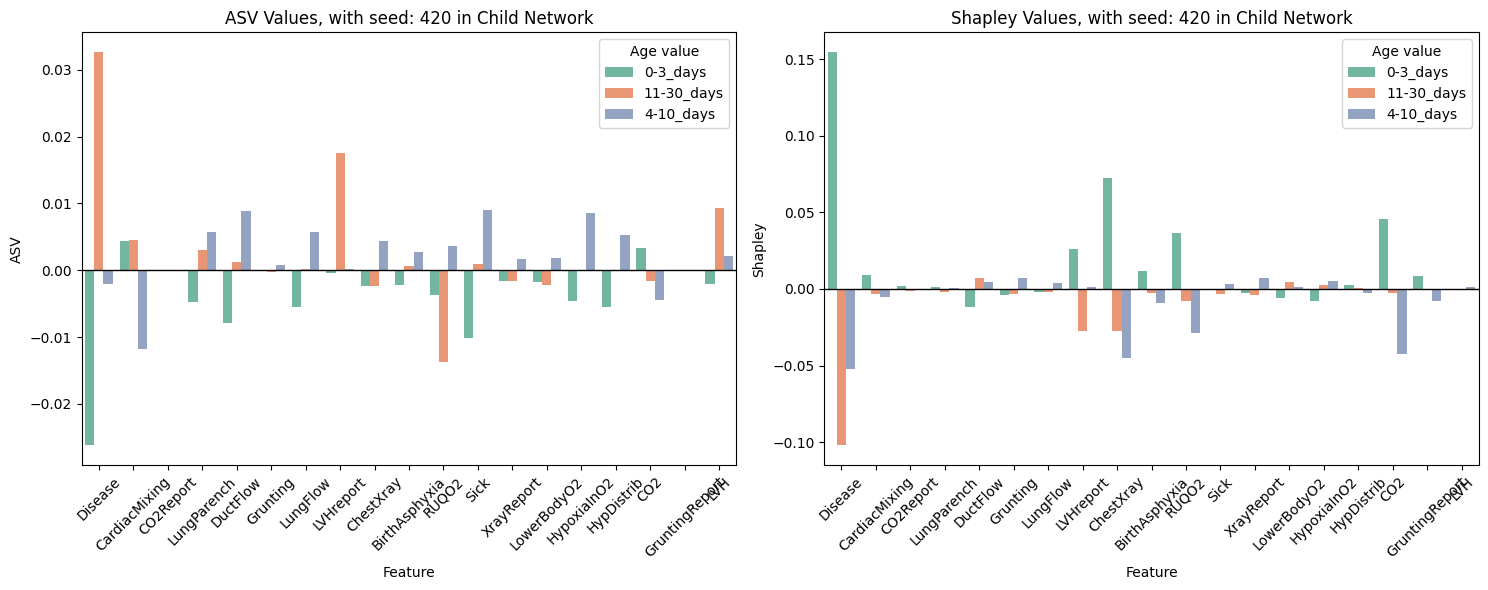

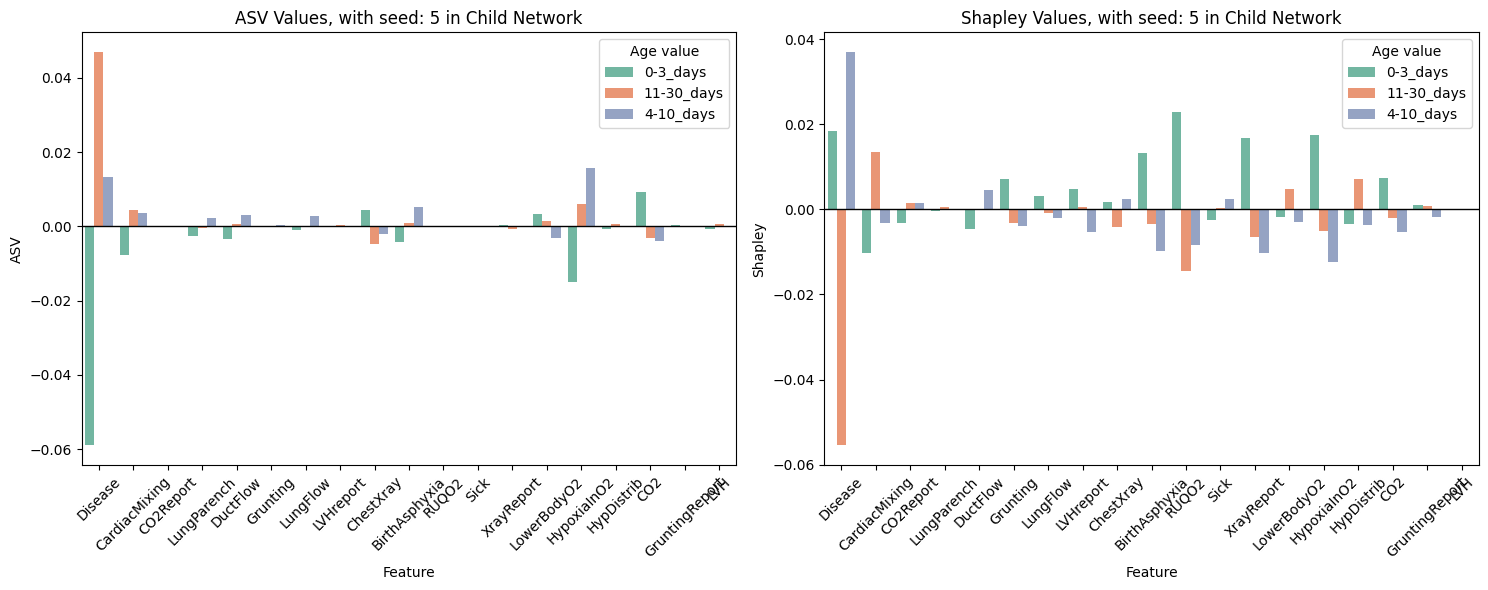

In [24]:
def plotValuesFromDF(ax, df, valueToPlot, hueValue, seed, paletteValue='Set2'):
    sns.barplot(x="Feature", y=valueToPlot, hue=hueValue, data=df, palette=paletteValue, ax=ax)
    ax.axhline(0, color="black", linewidth=1)
    bayesianNetwork = 'Cancer' if 'cancer' in df.name.lower() else 'Child'
    ax.set_title(f"{valueToPlot} Values, with seed: {seed} in {bayesianNetwork} Network")
    ax.set_ylabel(valueToPlot)
    ax.set_xlabel("Feature")
    if hueValue == 'Age value':
        ax.tick_params(axis='x', rotation=45)
    ax.legend(title=hueValue)


def plotASVandShapFromDF(df, hueValue, seed):
    _, axes = plt.subplots(1, 2, figsize=(15, 6))
    plotValuesFromDF(axes[0], df, 'ASV', hueValue, seed)
    plotValuesFromDF(axes[1], df, 'Shapley', hueValue, seed)
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.savefig(f"{plotsResultsFolder}{df.name}ASVAndShapley.png")
    plt.show()

for seed, df in dfCancerExactDict.items():
    plotASVandShapFromDF(df, 'Smoker value', seed)

for seed, df in dfChildExactDict.items():
    plotASVandShapFromDF(df, 'Age value', seed)


## Analyzing Networks Probabilities

In [1]:
from pgmpy.readwrite import BIFReader
from asvFormula.bayesianNetworks import networkSamplesPath

cancerNetworkPath = networkSamplesPath + "/cancer.bif"
completeCancerBNModel = BIFReader(cancerNetworkPath).get_model()

In [11]:
import pandas as pd
from pgmpy.inference import VariableElimination
import itertools

infer = VariableElimination(completeCancerBNModel)

# Function to add query results and compute differences
def add_query_rows(variable, values, variableToPredict, rows):
    state_names = completeCancerBNModel.get_cpds(variableToPredict).state_names[variableToPredict]
    probs = {state_val: {} for state_val in state_names}

    for val in values:
        result = infer.query(variables=[variableToPredict], evidence={variable: val})
       
        for i, state_val in enumerate(state_names):
            prob = round(result.values[i], 4)
            probs[state_val][val] = prob

            rows.append({
                "Variable": f"{variable} = {val}",
                variableToPredict: state_val,
                f"phi({variableToPredict})": prob,
            })

    # Collect all rows for this variable and Smoker=True
    for state in state_names:
        same_state_rows = [row for row in rows if row[variableToPredict] == state]

        # Extract the probabilities
        probs = [row[f"phi({variableToPredict})"] for row in same_state_rows]

        # Compare all pairs to find the max difference
        max_diff = 0.0
        for p1, p2 in itertools.combinations(probs, 2):
            max_diff = max(max_diff, abs(p1 - p2))

        # Update those rows with the max difference
        for row in same_state_rows:
            row["Max difference"] = round(max_diff, 4)

rows = []
add_query_rows("Cancer", ["True", "False"], "Smoker", rows)
add_query_rows("Xray", ["positive", "negative"], "Smoker", rows)

df = pd.DataFrame(rows)

print(df)


          Variable Smoker  phi(Smoker)  Max difference
0    Cancer = True   True       0.8255          0.5317
1    Cancer = True  False       0.1745          0.5317
2   Cancer = False   True       0.2938          0.5317
3   Cancer = False  False       0.7062          0.5317
4  Xray = positive   True       0.3206          0.5317
5  Xray = positive  False       0.6794          0.5317
6  Xray = negative   True       0.2946          0.5317
7  Xray = negative  False       0.7054          0.5317
